# We ROLLed dice and tried to see which ones are loaded!

In [9]:
import numpy as np
import random
import sys
import math
import matplotlib.pyplot as plt

In [10]:
#Game of dice. We sample two dice and add their corresponding face. 
#If the house wins we return a one, else zero.

def Rolling(PosOut, Probs, ProbsHouse):
    
    Sum1 = 0
    Sum2 = 0
    
    while Sum1 == Sum2:
        
        value1 = np.random.multinomial(n=PosOut, pvals=ProbsHouse)
        value2 = np.random.multinomial(n=PosOut, pvals=Probs)
    
        Sum1 = sum(np.where(value1 !=0)[0]) + 2
        Sum2 = sum(np.where(value2 !=0)[0]) + 2
        
        if len(np.where(value1 !=0)[0]) == 1: #Degeneracies 
            Sum1 = 2*sum(np.where(value1 !=0)[0]) + 2
        elif len(np.where(value2 !=0)[0]) == 1:
            Sum2 = 2*sum(np.where(value2 !=0)[0]) + 2
        
    if Sum2 > Sum1: #House won
        return 0
    else:
        return 1    #House lost
        

In [11]:
#Parameters = [file_name,nexp,rolls,dice,probs,probsbias]
#This function takes in the above variables and returns data for our game. 
def Data_Giver(parameters):
    file_name = parameters[0]
    nexp      = parameters[1]
    rolls     = parameters[2]
    dice      = parameters[3]
    prob      = parameters[4]
    probias   = parameters[5]
    
    
    outfile = open(file_name, 'w+')
    for e in range(0,nexp):
        for t in range(0,roll):
            outfile.write(str(Rolling(dice, prob, prob))+" ")
        outfile.write(" \n")
    outfile.close()

    
    biased_file = file_name.split('.')[0]+ 'Bias.txt'
    outfile = open(biased_file, 'w+')
    for e in range(0,nexp):
        for t in range(0,roll):
            outfile.write(str(Rolling(dice, prob, probias))+" ")
        outfile.write(" \n")
    outfile.close()

In [12]:
# returns the LLR and the LH. We employ a bernouili distribution for our computation
def Distribution(file_name):
    Ntoss = 1
    p0= .505
    p1 = 1-p0
    haveH0 = True
    haveH1 = True

    Npass0 = []
    LogLikeRatio0 = []
    Npass1 = []
    LogLikeRatio1 = []

    Npass_min = 1e8
    Npass_max = -1e8
    LLR_min = 1e8
    LLR_max = -1e8
    
    InputFile0 = file_name[0]
    InputFile1 = file_name[1]

    with open(InputFile0) as ifile: #Opens files
        for line in ifile: #
            lineVals = line.split() #splits lines ups
            Ntoss = len(lineVals) #obtains the number of toss
            Npass = 0 #defines the number of experiments
            LLR = 0
            for v in lineVals:
                Npass += float(v)
                # adding LLR for this toss
                if float(v) >= 1:
                    LLR += math.log( p1/p0 ) #transformation 
                else:
                    LLR += math.log( (1.-p1)/(1.-p0) )

            if Npass < Npass_min:
                Npass_min = Npass
            if Npass > Npass_max:
                Npass_max = Npass 
            if LLR < LLR_min:
                LLR_min = LLR
            if LLR > LLR_max:
                LLR_max = LLR #Updates the number of current iterations 
            Npass0.append(Npass)
            LogLikeRatio0.append(LLR)

    if haveH1:
        with open(InputFile1) as ifile:
            for line in ifile:
                lineVals = line.split()
                Ntoss = len(lineVals)
                Npass = 0
                LLR = 0
                for v in lineVals:
                    Npass += float(v);
                    # adding LLR for this toss
                    if float(v) >= 1:
                        LLR += math.log( p1/p0 )
                    else:
                        LLR += math.log( (1.-p1)/(1.-p0) )

                if Npass < Npass_min:
                    Npass_min = Npass
                if Npass > Npass_max:
                    Npass_max = Npass
                if LLR < LLR_min:
                    LLR_min = LLR
                if LLR > LLR_max:
                    LLR_max = LLR
                Npass1.append(Npass)
                LogLikeRatio1.append(LLR)

    return [Npass0,LogLikeRatio0, Npass1, LogLikeRatio1,Ntoss] 

In [18]:
#plot_params = [Npass0,LogLikeRatio0, Npass1, LogLikeRatio1] 
#Plot of our data. It reques the above parameters. 
def Plots(plot_params,haveH1,alp):
    Npass0        = plot_params[0]
    LogLikeRatio0 = plot_params[1]
    Npass1        = plot_params[2]
    LogLikeRatio1 = plot_params[3]
    Ntoss         = plot_params[4]
    haveH1        = haveH1
    sigma1 = 0
    mean1 = 0  
            
    sigma0 = 0
    mean0 = 0
    
    title = str(Ntoss) +  " tosses / experiment"

    # make Npass figure
    plt.figure()
    dos0 = plt.hist(Npass0, Ntoss+1, density=True, facecolor='b', stacked =True, alpha=0.7, label="assuming $\\mathbb{H}_0$")
    if haveH1:
        dos1 = plt.hist(Npass1, Ntoss+1, density=True, facecolor='g', alpha=0.7,stacked = True, label="assuming $\\mathbb{H}_1$")
        sigma1 = np.std(dos1[1])
        mean1 = np.mean(dos1[1])  
        plt.axvspan(mean1-sigma1, mean1+sigma1, alpha=0.1, color='orange',label = '$\sigma+\\mu$')
        plt.legend()
            
    sigma0 = np.std(dos0[1])
    mean0 = np.mean(dos0[1])
   
    plt.xlabel('$\\lambda = N_{pas}$')
    plt.ylabel('Probability')
    plt.title(title)
    plt.axvspan(mean0-sigma0, sigma0+mean0, alpha=0.1, color='red',label = '$\\sigma+\\mu$')
    #plt.xlim(35,50)
    plt.grid(True)
    plt.legend()
    plt.show()

    # make LLR figure
    plt.figure()
    dos0LL = plt.hist(LogLikeRatio0, Ntoss+1, density=True, stacked =True,facecolor='b', alpha=0.7, label="assuming $\\mathbb{H}_0$")
    if haveH1:
        dos1LL = plt.hist(LogLikeRatio1, Ntoss+1, density=True, stacked =True, facecolor='g', alpha=0.7, label="assuming $\\mathbb{H}_1$")
        plt.legend()
        sigma1 = np.std(dos1LL[1])
        mean1 = np.mean(dos1LL[1])  
        plt.axvspan(mean1-sigma1, mean1+sigma1, alpha=0.1, color='orange',label = '$\\sigma+\\mu$')
            
    sigma0 = np.std(dos0LL[1])
    mean0 = np.mean(dos0LL[1]) 
    
    params = [dos0,dos0LL, dos1,dos1LL]
    crit_val,beta,power,remainder = Alpha_Und_Beta(params,alp)

    plt.xlabel('$\\lambda = \\log({\\cal L}_{\\mathbb{H}_{1}}/{\\cal L}_{\\mathbb{H}_{0}})$')
    plt.ylabel('Probability')
    plt.title(title)
    plt.axvspan(mean0-sigma0, sigma0, alpha=0.1, color='red',label = '$\\sigma+\\mu$')
    plt.axhline(y = crit_val, color = 'r', linestyle = '--', label = 'Critical value')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    if haveH1:
        return [dos0,dos1,dos0LL,dos1LL]
    else:
        return [dos0,dos0LL]
    

In [20]:
#Significance testing of our data.
def Alpha_Und_Beta(Dos_Params,alph):
    
    Dos0   = Dos_Params[0]
    Dos0LL = Dos_Params[1]
    Dos1   = Dos_Params[2]
    Dos1LL = Dos_Params[3]
    
    sigma0 = np.std(Dos0[1])
    sigma1 = np.std(Dos1[1])

    mean0 = np.mean(Dos0[1])
    mean1 = np.mean(Dos1[1])

    Dos0 = np.array(Dos0)
    Dos1 = np.array(Dos1)

    alpha     = alph #Incorrectly rejected the null % of the time - rejecting the null while it's true. 
    crit_val  = 10*Dos0LL[0][min(int((1-alpha)*len(Dos0LL[0])),len(Dos0LL[0])-1)]
    remainder = np.where(Dos1LL[0] > crit_val)[0][0] #The 10 is due to the LLR being in 
    beta      = remainder/len(Dos1LL[0]) #"The portion of the alternative distribution that falls on 
    power     = 1-beta                 # the non-rejection side of the critical value."

    # Most of the data falls within one sigma. Let's use two sigma as or confidence 
    print("This is obtained critical value, beta and power respectively: " + str(crit_val)+" "+str(beta)+" "+ str(power))
    return [crit_val,beta,power,remainder]

In [6]:
nexp = 1000
roll = 100
dice = 2

probs        = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]  # [1,2,3,4,5,6]
probias      = [0, 0, 0, 3/9, 3/9, 3/9]  # [1,2,3,4,5,6]

file_name    = 'RollsEgr.txt'

parameters   = [file_name,nexp,roll,dice,probs,probias]

Data_Giver(parameters)

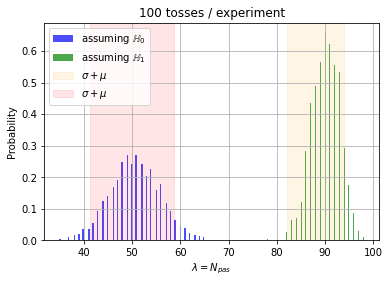

<ipython-input-20-7fd674f45763>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos0 = np.array(Dos0)
<ipython-input-20-7fd674f45763>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos1 = np.array(Dos1)


This is obtained critical value, beta and power respectively: 2.5249158310887547 0.1485148514851485 0.8514851485148515


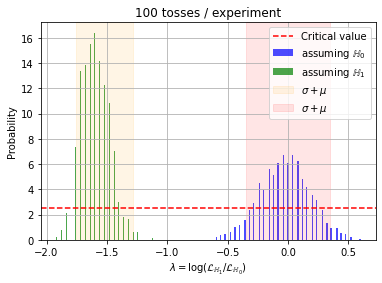

In [21]:
InputFile0 = "RollsEgr.txt"
InputFile1 = "RollsEgrBias.txt"
file_names = [InputFile0,InputFile1]
Dos0,Dos1,Dos0LL,Dos1LL  = Plots(Distribution(file_names),True,0.06)
#Dos0,Dos0LL  = Plots(Distribution(file_names),False)

In [29]:
probs        = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]  # [1,2,3,4,5,6]
probias      = [1/9, 1/9, 2/9, 2/9, 2/9, 1/9]  # [1,2,3,4,5,6]

file_name    = 'RollsMid.txt'

parameters   = [file_name,nexp,roll,dice,probs,probias]

Data_Giver(parameters)

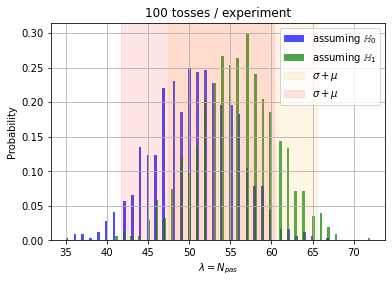

<ipython-input-20-7fd674f45763>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos0 = np.array(Dos0)
<ipython-input-20-7fd674f45763>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos1 = np.array(Dos1)


This is obtained critical value, beta and power respectively: 2.367108591645699 0.31683168316831684 0.6831683168316831


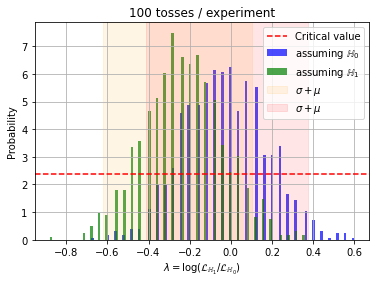

In [22]:
InputFile0 = "RollsMid.txt"
InputFile1 = "RollsMidBias.txt"
file_names = [InputFile0,InputFile1]
Dos0,Dos1,Dos0LL,Dos1LL  = Plots(Distribution(file_names),True,0.06)
#Dos0,Dos0LL  = Plots(Distribution(file_names),False)

In [16]:
probs        = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]  # [1,2,3,4,5,6]
probias      = [3/9, 3/9, 3/9, 0, 0, 0]  # [1,2,3,4,5,6]

file_name    = 'RollsAu.txt'

parameters   = [file_name,nexp,roll,dice,probs,probias]

Data_Giver(parameters)

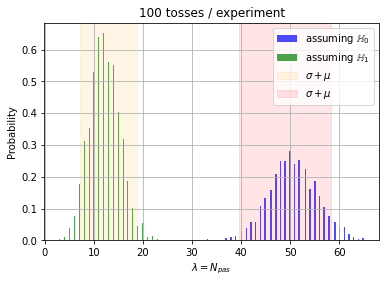

<ipython-input-20-7fd674f45763>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos0 = np.array(Dos0)
<ipython-input-20-7fd674f45763>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos1 = np.array(Dos1)


This is obtained critical value, beta and power respectively: 0.0 0.0 1.0


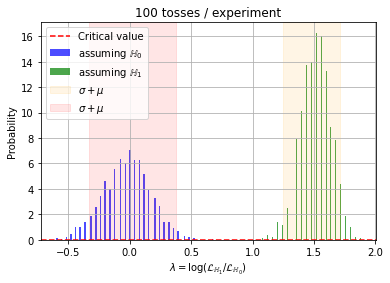

In [23]:
InputFile0 = "RollsAu.txt"
InputFile1 = "RollsAuBias.txt"
file_names = [InputFile0,InputFile1]
Dos0,Dos1,Dos0LL,Dos1LL  = Plots(Distribution(file_names),True,0.06)
#Dos0,Dos0LL  = Plots(Distribution(file_names),False)

In [26]:
probs        = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]  # [1,2,3,4,5,6]
probias      = [1/9, 2/9, 2/9, 2/9, 2/9, 0]  # [1,2,3,4,5,6]

file_name    = 'RollsPt.txt'

parameters   = [file_name,nexp,roll,dice,probs,probias]

Data_Giver(parameters)

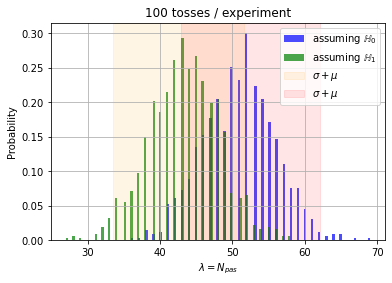

<ipython-input-20-7fd674f45763>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos0 = np.array(Dos0)
<ipython-input-20-7fd674f45763>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Dos1 = np.array(Dos1)


This is obtained critical value, beta and power respectively: 0.7651260094208373 0.18811881188118812 0.8118811881188119


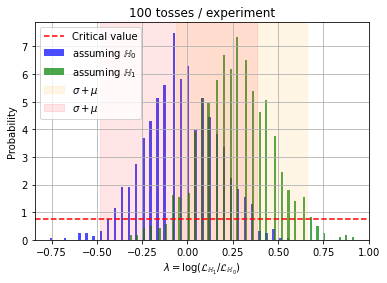

In [24]:
InputFile0 = "RollsPt.txt"
InputFile1 = "RollsPtBias.txt"
file_names = [InputFile0,InputFile1]
Dos0,Dos1,Dos0LL,Dos1LL  = Plots(Distribution(file_names),True,0.009)
#Dos0,Dos0LL  = Plots(Distribution(file_names),False)

In [245]:
sigma0 = np.std(Dos0[1])
sigma1 = np.std(Dos1[1])

mean0 = np.mean(Dos0[1])
mean1 = np.mean(Dos1[1])

print(sigma0,sigma1)
print(mean0,mean1)
print(mean0+sigma0*1)

Dos0 = np.array(Dos0)
Dos1 = np.array(Dos1)

alpha     = 0.06 #Incorrectly rejected the null 6% of the time - rejecting the null while it's true. 
crit_val  = Dos0LL[0][min(int((1-alpha)*len(Dos0LL[0])),len(Dos0LL[0])-1)]
remainder = np.where(Dos1LL[0] > crit_val)[0][0]
beta      = remainder/len(Dos1LL[0]) #"Incorrectly retainting the null"
power     = 1-beta # The portion of the alternative distribution that falls on the rejection side of the critical value

# Most of the data falls within one sigma. Let's use two sigma as or confidence 

print(crit_val,beta,power,remainder)

9.620136677977621 9.037098091433522
52.49999999999999 42.5
62.12013667797761
0.38256300471042193 0.0594059405940594 0.9405940594059405 6
